In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import lightgbm as lgb
from sklearn.kernel_ridge import KernelRidge

from multiprocessing import Lock, Manager
from multiprocessing.pool import Pool
from multiprocessing import cpu_count
import time

import seaborn

### first step: generate data ###

In [2]:
d  = 20

nrep = 10
beta = np.random.randn(d)

In [3]:
def getRandomSamplesOnNSphere(N , numberOfSamples, R = 1):
    X = np.random.default_rng().normal(size=(numberOfSamples , N))
    return R / np.sqrt(np.sum(X**2, 1, keepdims=True)) * X

In [4]:
def generate_y(x,beta):
    # x is numpy array with (n,d) ,beta is (d) and fixed
    N = x.shape[0]
    d = x.shape[1]
    e = np.random.normal(0, 0.5,size = N)
    vector = np.einsum('i,ij -> j', beta,x.T)
    fx = np.sqrt(4/10)*vector + np.sqrt(4/10)*(np.sqrt(1/2)*(vector**2-1))+ \
        np.sqrt(2/10)*(np.sqrt(1/10)*(vector**4 - 6*vector**2 + 3))
    y = fx + e
    return y

### second step: model ###

In [5]:
class dataset(Dataset):
    def __init__(self, data_tensor, data_target):
        self.data_target = data_target
        self.data_tensor = data_tensor 
    
    def __len__(self):
        return self.data_target.shape[0]

    def __getitem__(self, index):
        return self.data_tensor[index], self.data_target[index]



In [6]:
class Model_1(nn.Module):
    def __init__(self, input_dim, Nd = 100, drop_rate = 0.0, ):
        super(Model_1,self).__init__()
        self.model_name = '2 layer linear nn'
        
        self.hidden_dim = Nd//input_dim
        
        self.linear1 = nn.Linear(input_dim,self.hidden_dim)
        self.act = nn.ReLU()
        self.linear2 = nn.Linear(self.hidden_dim,1)

        # torch.set_num_threads(1)

#         for p in self.linear1.parameters():
#             nn.init.normal_(p,mean=0.0,std = 0.001)
#         for p in self.linear2.parameters():
#             nn.init.normal_(p,mean=0.0,std = 0.001)


    def forward(self,x):

        x_signal = self.linear1(x)
        x_signal = self.act(x_signal)
        out = self.linear2(x_signal)

        return out

In [12]:
class Model_2(nn.Module):
    def __init__(self, input_dim, Nd = 100, drop_rate = 0.0, ):
        super(Model_2,self).__init__()
        self.model_name = '2 layer linear nn'
        
        self.hidden_dim = Nd//input_dim
        
        self.linear1 = nn.Linear(input_dim,self.hidden_dim,bias=False)
        self.act = nn.ReLU()

        # torch.set_num_threads(1)

#         for p in self.linear1.parameters():
#             nn.init.normal_(p,mean=0.0,std = 0.001)
#         for p in self.linear2.parameters():
#             nn.init.normal_(p,mean=0.0,std = 0.001)


    def forward(self,x):

        x_signal = self.linear1(x)
        x_signal = self.act(x_signal)

        out = x_signal @ torch.FloatTensor([[1 if x%2==0 else -1 for x in range(x_signal.shape[1])]]).T

        return out

In [13]:

result_trainingerror = np.zeros((40,20))
result_testerror = np.zeros((40,20))    

for i in range(20,60):
    x_id = i /20
    for j in range(20,40):
        y_id = j/20
        
        N = int(np.ceil(np.e**(y_id * np.log(20))))
        Nd = int(np.ceil(np.e**(x_id* np.log(20))))
        
        for nrepitition in range(nrep):
            x = getRandomSamplesOnNSphere(d,N)
            y = generate_y(x,beta)

            x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2,shuffle = True)
            x_train = torch.FloatTensor(x_train)
            x_test = torch.FloatTensor(x_test)
            y_train = torch.FloatTensor(y_train).unsqueeze(1)
            y_test = torch.FloatTensor(y_test).unsqueeze(1)

            train_dataset = dataset(x_train, y_train)
            test_dataset = dataset(x_test, y_test)
            train_dataloader = DataLoader(dataset= train_dataset, 
                                        batch_size = len(x_train), 
                                        shuffle= True, 
                                        drop_last= False)
            test_dataloader = DataLoader(dataset= test_dataset, 
                                        batch_size = len(x_test), 
                                        shuffle= True, 
                                        drop_last= False)
            torch.cuda.empty_cache()

            lr = 0.01

            device = torch.device('cuda:0'if torch.cuda.is_available() else 'cpu')
            model = Model_1(input_dim= d, Nd = Nd,drop_rate= 0.0).to(device)
            criterion = nn.MSELoss()
            optimizer = optim.Adam(model.parameters(), lr)
            LOSS = 0
            LOSS2 = 0
            model.train()
            
            for epoch in range(500):

                for index, (x, y) in enumerate(train_dataloader):
                    if torch.cuda.is_available():
                        x = x.to(device)
                        y = y.to(device)
                    y_pred = model(x)
                    loss = criterion(y_pred,y)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            #         for p in model.parameters():
            #             # print(p.grad.norm())                 
            #             torch.nn.utils.clip_grad_norm_(p, 10)  
            #         optimizer.step()
            LOSS += loss
            model.eval()
            loss2 = criterion(model(x_test), y_test)
            
            LOSS2 += loss2
            
        training_error = LOSS /nrep
        test_error = LOSS2 /nrep
        
        result_trainingerror[i-20][j-20] = training_error
        result_testerror[i-20][j-20] = test_error
        
        print('Nd: %d, N: %d,trainingerror: %f, testerror: %f'%(Nd,N, training_error, test_error))
        
    np.save('./result/trainingerror.npy',result_trainingerror)
    np.save('./result/testerror.npy',result_testerror)    
         




Nd: 20, N: 20,trainingerror: 0.000001, testerror: 0.066404
Nd: 20, N: 24,trainingerror: 0.043282, testerror: 0.077619
Nd: 20, N: 27,trainingerror: 0.002557, testerror: 0.018265
Nd: 20, N: 32,trainingerror: 0.013802, testerror: 0.108643
Nd: 20, N: 37,trainingerror: 0.017974, testerror: 0.033381
Nd: 20, N: 43,trainingerror: 0.003823, testerror: 0.099286


KeyboardInterrupt: 

In [16]:

result_trainingerror = np.zeros((15,40))
result_testerror = np.zeros((15,40))    

for i in range(65,80):
    x_id = i /20
    for j in range(20,60):
        y_id = j/20
        
        N = int(np.ceil(np.e**(y_id * np.log(20))))
        Nd = int(np.ceil(np.e**(x_id* np.log(20))))
        
        for nrepitition in range(nrep):
            x = getRandomSamplesOnNSphere(d,N)
            y = generate_y(x,beta)

            x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2,shuffle = True)
            x_train = torch.FloatTensor(x_train)
            x_test = torch.FloatTensor(x_test)
            y_train = torch.FloatTensor(y_train).unsqueeze(1)
            y_test = torch.FloatTensor(y_test).unsqueeze(1)

            train_dataset = dataset(x_train, y_train)
            test_dataset = dataset(x_test, y_test)
            train_dataloader = DataLoader(dataset= train_dataset, 
                                        batch_size = len(x_train), 
                                        shuffle= True, 
                                        drop_last= False)
            test_dataloader = DataLoader(dataset= test_dataset, 
                                        batch_size = len(x_test), 
                                        shuffle= True, 
                                        drop_last= False)
            torch.cuda.empty_cache()

            lr = 0.01

            device = torch.device('cuda:0'if torch.cuda.is_available() else 'cpu')
            model = Model_2(input_dim= d, Nd = Nd,drop_rate= 0.0).to(device)
            criterion = nn.MSELoss()
            optimizer = optim.Adam(model.parameters(), lr)
            LOSS = 0
            LOSS2 = 0
            model.train()
            
            for epoch in range(500):

                for index, (x, y) in enumerate(train_dataloader):
                    if torch.cuda.is_available():
                        x = x.to(device)
                        y = y.to(device)
                    y_pred = model(x)
                    loss = criterion(y_pred,y)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            #         for p in model.parameters():
            #             # print(p.grad.norm())                 
            #             torch.nn.utils.clip_grad_norm_(p, 10)  
            #         optimizer.step()
            LOSS += loss
            model.eval()
            loss2 = criterion(model(x_test), y_test)
            
            LOSS2 += loss2
            
        training_error = LOSS /nrep
        test_error = LOSS2 /nrep
        
        result_trainingerror[i-65][j-20] = training_error
        result_testerror[i-65][j-20] = test_error
        
        print('Nd: %d, N: %d,trainingerror: %f, testerror: %f'%(Nd,N, training_error, test_error))
        
    np.save('./result2/trainingerror3.npy',result_trainingerror)
    np.save('./result2/testerror3.npy',result_testerror)    
         


Nd: 16918, N: 20,trainingerror: 0.000282, testerror: 0.209758
Nd: 16918, N: 24,trainingerror: 0.000022, testerror: 0.421224
Nd: 16918, N: 27,trainingerror: 0.000000, testerror: 0.139345
Nd: 16918, N: 32,trainingerror: 0.000036, testerror: 0.274655
Nd: 16918, N: 37,trainingerror: 0.000000, testerror: 0.350901
Nd: 16918, N: 43,trainingerror: 0.000206, testerror: 0.211244
Nd: 16918, N: 50,trainingerror: 0.000000, testerror: 0.508617
Nd: 16918, N: 58,trainingerror: 0.000013, testerror: 0.186511
Nd: 16918, N: 67,trainingerror: 0.000000, testerror: 0.281472
Nd: 16918, N: 78,trainingerror: 0.000000, testerror: 0.178138
Nd: 16918, N: 90,trainingerror: 0.002985, testerror: 0.113141
Nd: 16918, N: 104,trainingerror: 0.000000, testerror: 0.196704
Nd: 16918, N: 121,trainingerror: 0.000002, testerror: 0.357221
Nd: 16918, N: 141,trainingerror: 0.000153, testerror: 0.181106
Nd: 16918, N: 163,trainingerror: 0.000658, testerror: 0.112125
Nd: 16918, N: 190,trainingerror: 0.000001, testerror: 0.103209
Nd:

Nd: 26516, N: 104,trainingerror: 0.000023, testerror: 0.166262
Nd: 26516, N: 121,trainingerror: 0.000000, testerror: 0.226158
Nd: 26516, N: 141,trainingerror: 0.001499, testerror: 0.216248
Nd: 26516, N: 163,trainingerror: 0.000000, testerror: 0.576505
Nd: 26516, N: 190,trainingerror: 0.000002, testerror: 0.182346
Nd: 26516, N: 220,trainingerror: 0.000001, testerror: 0.215058
Nd: 26516, N: 256,trainingerror: 0.000095, testerror: 0.201532
Nd: 26516, N: 297,trainingerror: 0.000000, testerror: 0.144044
Nd: 26516, N: 345,trainingerror: 0.000000, testerror: 0.157943
Nd: 26516, N: 400,trainingerror: 0.000003, testerror: 0.113357
Nd: 26516, N: 465,trainingerror: 0.001506, testerror: 0.153301
Nd: 26516, N: 540,trainingerror: 0.000000, testerror: 0.121935
Nd: 26516, N: 627,trainingerror: 0.000023, testerror: 0.103877
Nd: 26516, N: 729,trainingerror: 0.000000, testerror: 0.154857
Nd: 26516, N: 846,trainingerror: 0.000000, testerror: 0.065193
Nd: 26516, N: 983,trainingerror: 0.000000, testerror: 0

Nd: 41559, N: 465,trainingerror: 0.001279, testerror: 0.127864
Nd: 41559, N: 540,trainingerror: 0.000000, testerror: 0.106684
Nd: 41559, N: 627,trainingerror: 0.003662, testerror: 0.151655
Nd: 41559, N: 729,trainingerror: 0.000000, testerror: 0.093831
Nd: 41559, N: 846,trainingerror: 0.000000, testerror: 0.102779
Nd: 41559, N: 983,trainingerror: 0.000000, testerror: 0.095068
Nd: 41559, N: 1142,trainingerror: 0.000000, testerror: 0.099021
Nd: 41559, N: 1326,trainingerror: 0.000000, testerror: 0.089282
Nd: 41559, N: 1541,trainingerror: 0.000000, testerror: 0.079227
Nd: 41559, N: 1789,trainingerror: 0.004718, testerror: 0.077633
Nd: 41559, N: 2078,trainingerror: 0.000000, testerror: 0.074626
Nd: 41559, N: 2414,trainingerror: 0.000000, testerror: 0.071239
Nd: 41559, N: 2804,trainingerror: 0.000000, testerror: 0.079178
Nd: 41559, N: 3257,trainingerror: 0.000000, testerror: 0.078857
Nd: 41559, N: 3783,trainingerror: 0.000000, testerror: 0.066453
Nd: 41559, N: 4395,trainingerror: 0.000217, te

Nd: 65135, N: 2078,trainingerror: 0.000000, testerror: 0.088440
Nd: 65135, N: 2414,trainingerror: 0.000000, testerror: 0.091088
Nd: 65135, N: 2804,trainingerror: 0.000000, testerror: 0.086546
Nd: 65135, N: 3257,trainingerror: 0.000000, testerror: 0.085447
Nd: 65135, N: 3783,trainingerror: 0.000000, testerror: 0.078052
Nd: 65135, N: 4395,trainingerror: 0.000001, testerror: 0.087719
Nd: 65135, N: 5105,trainingerror: 0.000001, testerror: 0.083684
Nd: 65135, N: 5930,trainingerror: 0.000018, testerror: 0.083554
Nd: 65135, N: 6888,trainingerror: 0.000047, testerror: 0.078441
Nd: 75660, N: 20,trainingerror: 0.000000, testerror: 0.901443
Nd: 75660, N: 24,trainingerror: 0.000002, testerror: 4.290855
Nd: 75660, N: 27,trainingerror: 0.000156, testerror: 1.093058
Nd: 75660, N: 32,trainingerror: 0.000000, testerror: 0.871604
Nd: 75660, N: 37,trainingerror: 0.000000, testerror: 1.915780
Nd: 75660, N: 43,trainingerror: 0.004284, testerror: 1.062808
Nd: 75660, N: 50,trainingerror: 0.000003, testerror:

Nd: 118582, N: 24,trainingerror: 0.000000, testerror: 3.079390
Nd: 118582, N: 27,trainingerror: 0.000000, testerror: 0.710095
Nd: 118582, N: 32,trainingerror: 0.000000, testerror: 2.277954
Nd: 118582, N: 37,trainingerror: 0.005015, testerror: 4.800510
Nd: 118582, N: 43,trainingerror: 0.000000, testerror: 3.851777
Nd: 118582, N: 50,trainingerror: 0.000000, testerror: 2.199324
Nd: 118582, N: 58,trainingerror: 0.095932, testerror: 2.087265
Nd: 118582, N: 67,trainingerror: 0.000000, testerror: 3.680948
Nd: 118582, N: 78,trainingerror: 0.000501, testerror: 1.984034
Nd: 118582, N: 90,trainingerror: 0.001196, testerror: 1.702834
Nd: 118582, N: 104,trainingerror: 0.000000, testerror: 1.240332
Nd: 118582, N: 121,trainingerror: 0.000000, testerror: 0.739029
Nd: 118582, N: 141,trainingerror: 0.000004, testerror: 1.208926
Nd: 118582, N: 163,trainingerror: 0.102096, testerror: 1.181790
Nd: 118582, N: 190,trainingerror: 0.000075, testerror: 1.041838
Nd: 118582, N: 220,trainingerror: 0.086735, tester

In [144]:
result_trainingerror = np.load('./result/trainingerror2.npy')
result_testerror = np.load('./result/testerror2.npy')

In [145]:
result_trainingerror[np.isnan(result_trainingerror)] = 0
result_testerror[np.isnan(result_testerror)] = 0.05

Text(0.5, 1.0, 'training error')

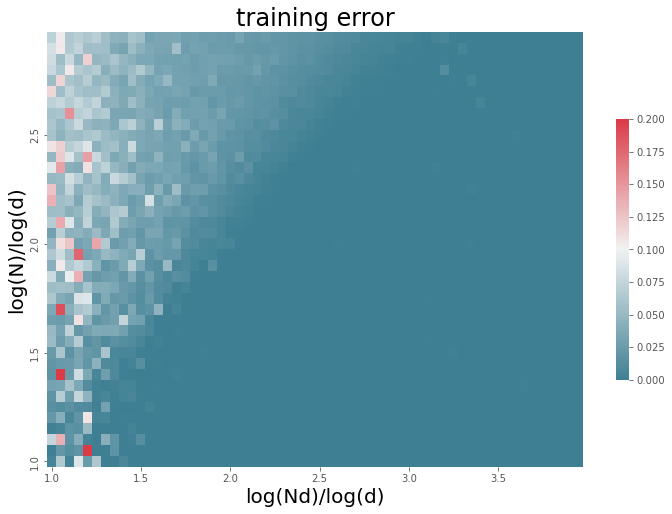

In [98]:
from matplotlib import ticker
cmap = seaborn.diverging_palette(220, 10, as_cmap=True)
f, ax = plt.subplots(figsize=(12, 8))

xxs = pd.DataFrame(result_trainingerror.T,index = [x/20+1 for x in list(range(result_trainingerror.shape[1]))],
            columns = [x/20+1 for x in list(range(result_trainingerror.shape[0]))])

seaborn.heatmap(xxs, cmap=cmap,vmin = 0,vmax = 0.2,
            linewidths=.0001, cbar_kws={"shrink": 0.6},xticklabels=10,yticklabels=10)

ax.invert_yaxis()

ax.set_ylabel('log(N)/log(d)',fontsize=20, color='k')

ax.set_xlabel('log(Nd)/log(d)',fontsize=20, color='k')

plt.title('training error', fontsize = 24,color = 'k')

Text(0.5, 1.0, 'test error')

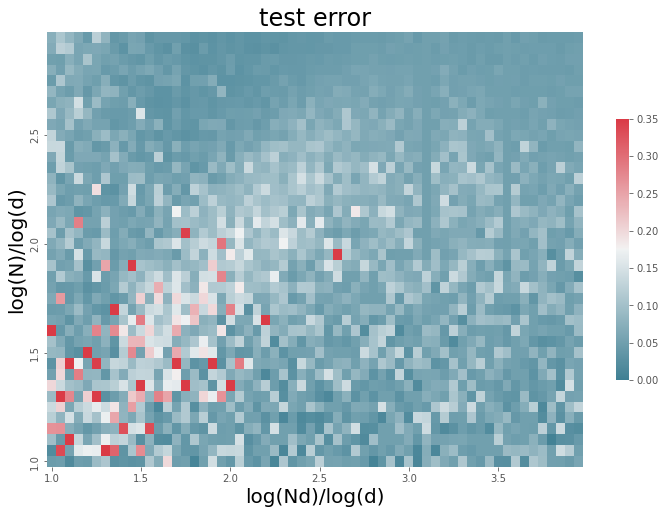

In [150]:
from matplotlib import ticker
cmap = seaborn.diverging_palette(220, 10, as_cmap=True)
f, ax = plt.subplots(figsize=(12, 8))

xxss = pd.DataFrame(result_testerror.T,index = [x/20+1 for x in list(range(result_testerror.shape[1]))],
            columns = [x/20+1 for x in list(range(result_trainingerror.shape[0]))])

seaborn.heatmap(xxss, cmap=cmap,vmin = 0,vmax = 0.35,
            linewidths=.0001, cbar_kws={"shrink": 0.6},xticklabels=10,yticklabels=10)

ax.invert_yaxis()

ax.set_ylabel('log(N)/log(d)',fontsize=20, color='k')

ax.set_xlabel('log(Nd)/log(d)',fontsize=20, color='k')

plt.title('test error', fontsize = 24,color = 'k')

<AxesSubplot:>

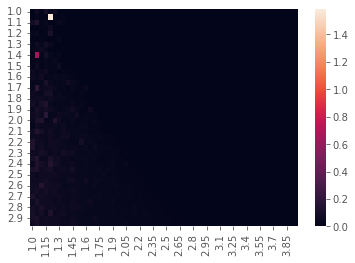

In [57]:
seaborn.heatmap(xxs)

In [65]:
?ax.xaxis.set_major_locator

In [146]:
for i in range(40,60):
    for j in range(40):
        if result_testerror[i][j]>0.15:
            result_testerror[i][j] = 0.05

In [149]:
for i in range(13,40):
    for j in range(40):
        if j< i-13:
            if result_testerror[i][j]>0.15:
                result_testerror[i][j] = 0.05

In [153]:
result_testerror[:,].shape

(60,)

In [8]:

result_trainingerror2 = np.zeros((45,1))
result_testerror2 = np.zeros((45,1))    
n_list = [4304]
for i in range(15,60):
    x_id = i /5
    for j in range(1):
        
        N = n_list[j]
        Nd = int(np.ceil(np.e**(x_id)))
        
        for nrepitition in range(nrep):
            x = getRandomSamplesOnNSphere(d,N)
            y = generate_y(x,beta)

            x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2,shuffle = True)
            x_train = torch.FloatTensor(x_train)
            x_test = torch.FloatTensor(x_test)
            y_train = torch.FloatTensor(y_train).unsqueeze(1)
            y_test = torch.FloatTensor(y_test).unsqueeze(1)

            train_dataset = dataset(x_train, y_train)
            test_dataset = dataset(x_test, y_test)
            train_dataloader = DataLoader(dataset= train_dataset, 
                                        batch_size = len(x_train), 
                                        shuffle= True, 
                                        drop_last= False)
            test_dataloader = DataLoader(dataset= test_dataset, 
                                        batch_size = len(x_test), 
                                        shuffle= True, 
                                        drop_last= False)
            torch.cuda.empty_cache()

            lr = 0.01

            device = torch.device('cuda:0'if torch.cuda.is_available() else 'cpu')
            model = Model_1(input_dim= d, Nd = Nd,drop_rate= 0.0).to(device)
            criterion = nn.MSELoss()
            optimizer = optim.Adam(model.parameters(), lr)
            LOSS = 0
            LOSS2 = 0
            model.train()
            
            for epoch in range(500):

                for index, (x, y) in enumerate(train_dataloader):
                    if torch.cuda.is_available():
                        x = x.to(device)
                        y = y.to(device)
                    y_pred = model(x)
                    loss = criterion(y_pred,y)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            #         for p in model.parameters():
            #             # print(p.grad.norm())                 
            #             torch.nn.utils.clip_grad_norm_(p, 10)  
            #         optimizer.step()
            LOSS += loss
            model.eval()
            loss2 = criterion(model(x_test), y_test)
            
            LOSS2 += loss2
            
        training_error = LOSS /nrep
        test_error = LOSS2 /nrep
        
        result_trainingerror2[i-15][j] = training_error
        result_testerror2[i-15][j] = test_error
        
        print('Nd: %d, N: %d,trainingerror: %f, testerror: %f'%(Nd,N, training_error, test_error))
        
    np.save('./result1/trainingerror3.npy',result_trainingerror2)
    np.save('./result1/testerror3.npy',result_testerror2)    
         



Nd: 21, N: 4304,trainingerror: 0.038534, testerror: 0.039103
Nd: 25, N: 4304,trainingerror: 0.071780, testerror: 0.088041
Nd: 30, N: 4304,trainingerror: 0.035909, testerror: 0.032923
Nd: 37, N: 4304,trainingerror: 0.038243, testerror: 0.038382
Nd: 45, N: 4304,trainingerror: 0.038411, testerror: 0.031417
Nd: 55, N: 4304,trainingerror: 0.036637, testerror: 0.037849
Nd: 67, N: 4304,trainingerror: 0.041629, testerror: 0.039218
Nd: 82, N: 4304,trainingerror: 0.034283, testerror: 0.037409
Nd: 100, N: 4304,trainingerror: 0.031243, testerror: 0.039221
Nd: 122, N: 4304,trainingerror: 0.033172, testerror: 0.033628
Nd: 149, N: 4304,trainingerror: 0.028770, testerror: 0.029483
Nd: 182, N: 4304,trainingerror: 0.029944, testerror: 0.029461
Nd: 222, N: 4304,trainingerror: 0.027739, testerror: 0.032456
Nd: 271, N: 4304,trainingerror: 0.026088, testerror: 0.032718
Nd: 331, N: 4304,trainingerror: 0.021922, testerror: 0.033112
Nd: 404, N: 4304,trainingerror: 0.026896, testerror: 0.036423
Nd: 493, N: 4304

In [156]:
np.ceil(4)

4.0

In [160]:
np.load('./result/trainingerror2.npy')

array([[4.55249753e-03, 1.44158979e-03, 7.52650797e-02, ...,
        8.16754401e-02, 8.37643072e-02, 7.15659857e-02],
       [6.35459274e-02, 2.04691030e-02, 1.36507645e-01, ...,
        5.32738343e-02, 1.04697391e-01, 1.04651690e-01],
       [3.37138842e-03, 1.32026123e-02, 1.73560716e-02, ...,
        7.87840188e-02, 6.46702275e-02, 6.29779771e-02],
       ...,
       [9.02083339e-17, 9.34924659e-17, 1.35605819e-16, ...,
        3.65336746e-06, 1.14787954e-05, 1.02914637e-04],
       [5.55111521e-18, 7.01193478e-18, 8.57118595e-17, ...,
        1.64825164e-04, 6.69850215e-06, 1.39008029e-04],
       [6.66188038e-17, 2.62947565e-18, 7.11071388e-17, ...,
        1.80096031e-04, 2.29380257e-05, 3.14147357e-04]])

In [162]:
list(range(1))

[0]

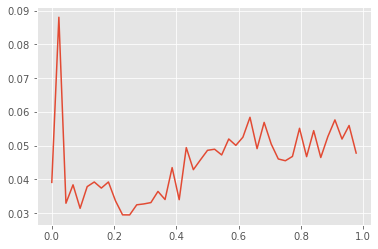

In [9]:
plt.plot(np.linspace(0,1,len(result_testerror2[0:,0])),result_testerror2[0:,0])

In [17]:
import skpp

In [18]:
from skpp import ProjectionPursuitRegressor

In [19]:
?ProjectionPursuitRegressor

In [20]:
ppr = ProjectionPursuitRegressor()

In [23]:
ppr.fit(np.array(x_train),np.array(y_train.squeeze(1)))

ProjectionPursuitRegressor()

In [27]:
criterion(torch.FloatTensor(ppr.predict(x_test)).unsqueeze(-1),y_test)

tensor(0.3953)